In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_compression as tfc
import matplotlib.pyplot as plt

import os
import h5py

from BalleFFP_improved import BalleFFP
from read_data import read_data_numpy

2023-03-07 16:12:46.450476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 16:12:46.587223: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-07 16:12:47.166931: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ubuntu/data/miniconda3/envs/tf2/lib/
2023-03-07 16:12:47.167058: W tensorflow/co

## General Settings

In [2]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [3]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 14

In [4]:
tf.config.set_visible_devices([], 'GPU')

2023-03-07 16:12:56.887087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 16:12:56.888199: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 16:12:56.897448: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 16:12:56.898509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 16:12:56.900211: I tensorflow/compiler/xla/stream_executo

## Functions

In [5]:
def get_model_files(folder, name):
    files  = os.listdir(folder)
    files  = [f for f in files if name in f]
    models = [f for f in files if "model" in f]
    losses = [f for f in files if "losses" in f]
    return models, losses

In [6]:
def show_image_comparison(img, reco, id, format):
    """Visualize the original image and the reconstructed image side by side."""
    if format=='channels_first':
        img  = np.transpose(img, (1, 2, 0))
        reco = np.transpose(reco, (1, 2, 0))
    
    # check if the images are normalized
    norm_img  = np.max(img)  <= 1.0
    norm_reco = np.max(reco) <= 1.0

    # Create a 4x4 grid of images
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), constrained_layout=True)
    axes[0].imshow(img  if norm_img  else img.astype(np.uint8)) 
    axes[1].imshow(reco if norm_reco else reco.astype(np.uint8)) 
    
    axes[0].axis('off')
    axes[1].axis('off')
    
    fig.suptitle('Original image (left) and reconstructed image (right) (id: {})'.format(id))

    # Show the plot
    plt.show()

def show_image_comparison_bitrate(img, reco, id, format, compressor):
    """Visualize the original image and the reconstructed image side by side."""
    if format=='channels_first':
        img  = np.transpose(img, (1, 2, 0))
        reco = np.transpose(reco, (1, 2, 0))
    
    # check if the images are normalized
    norm_img  = np.max(img)  <= 1.0
    norm_reco = np.max(reco) <= 1.0

    bits_img     = np.product(img.shape)*8
    _, bits_reco = compressor(np.expand_dims(img, 0))

    print('Bitrate shape:', bits_reco.shape)

    # Create a 4x4 grid of images
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), constrained_layout=True)
    axes[0].imshow(img  if norm_img  else img.astype(np.uint8)) 
    axes[1].imshow(reco if norm_reco else reco.astype(np.uint8)) 
    
    axes[0].axis('off')
    axes[1].axis('off')

    axes[0].set_title(f'{bits_img} bits')
    axes[1].set_title(f'{tf.reduce_sum(bits_reco):.2f} bits')
    
    fig.suptitle('Original image (left) and reconstructed image (right) (id: {})'.format(id))

    # Show the plot
    plt.show()

In [7]:
def select_random_images(data, n):
    """Selects n random images from the data."""
    idx = np.random.choice(data.shape[0], n, replace=False)
    return data[idx], idx

In [8]:
# Get the tab10 colormap from matplotlib
tab10 = plt.get_cmap('tab10') # type: ignore

# Get the number of colors in the tab10 colormap
num_colors = tab10.N

# Create a list to store the hex color codes
hex_colors = []

# Loop through each color in the tab10 colormap and convert it to a hex color code
for i in range(num_colors):
    rgb_color = tab10(i)[:3]  # Get the RGB values of the color
    hex_color = '#{:02x}{:02x}{:02x}'.format(*[int(x * 255) for x in rgb_color])  # Convert the RGB color to a hex color code
    hex_colors.append(hex_color)

# Print the list of hex color codes
print(hex_colors)


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [9]:
class Compressor(tf.keras.Model):

    def __init__(self, model, cr):

        super(Compressor, self).__init__()

        self.encoder = model.encoder
        self.prior   = model.prior
        self.bemodel = tfc.ContinuousBatchedEntropyModel(
            prior = self.prior,
            coding_rank=cr,
            compression=True
        )

    def call(self, inputs):

        encoded = self.encoder(inputs, training=False)

        _, bits   = self.bemodel(encoded, training=False)
        bitstring = self.bemodel.compress(encoded)

        return bitstring, bits

## Constants

In [10]:
DATA_FOLDER  = "../data/stl10/stl10_binary/"
DATA_FILE    = "unlabeled_X.bin"

CH_FORMAT = "channels_last"
EPOCHS    = 50
NORM      = "normFalse"
COD_RANK  = 1

MODEL_FOLDER = "../models/"

## Load Data

In [11]:
data_path = os.path.join(DATA_FOLDER, DATA_FILE)
data      = read_data_numpy(data_path, CH_FORMAT).astype('float32') 

if NORM == "normTrue":
    # normalize the data to [0,1]
    data = data / 255.0

## Choose the trained model

In [12]:
# name = "ffp_{}_epochs{}_{}_l{}_cr{}".format(CH_FORMAT, EPOCHS, NORM, LAMBDA, COD_RANK)
name = "cr1"

models, losses = get_model_files(MODEL_FOLDER, name)
for model in models:
    print(model)

model_ffp_channels_last_epochs50_normFalse_l0.01_cr1_20230307041231.h5
model_ffp_channels_last_epochs50_normFalse_l0.1_cr1_20230307055327.h5


In [13]:
# from the list of models find the lambda value right after "l" and before  the following "_"
lambdas = [float(model.split("_")[6].split("l")[1].split("_")[0]) for model in models]
print(lambdas)

[0.01, 0.1]


In [14]:
models_path = [os.path.join(MODEL_FOLDER, model) for model in models]
losses_path = [os.path.join(MODEL_FOLDER, loss) for loss in losses]

for model_path in models_path:
    print("Loading model from: {}".format(model_path))

Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l0.01_cr1_20230307041231.h5
Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l0.1_cr1_20230307055327.h5


## Train/Test loss

In [15]:
# for every loss file, load them as two numpy arrays train_loss and test_loss
train_losses = []   
test_losses  = []

for loss_path in losses_path:
    print("Loading losses from: {}".format(loss_path))
    with h5py.File(loss_path, 'r') as f:
        train_losses.append(np.array(f['train']))
        test_losses.append(np.array(f['test']))

Loading losses from: ../models/losses_ffp_channels_last_epochs50_normFalse_l0.01_cr1_20230307041231.h5
Loading losses from: ../models/losses_ffp_channels_last_epochs50_normFalse_l0.1_cr1_20230307055327.h5


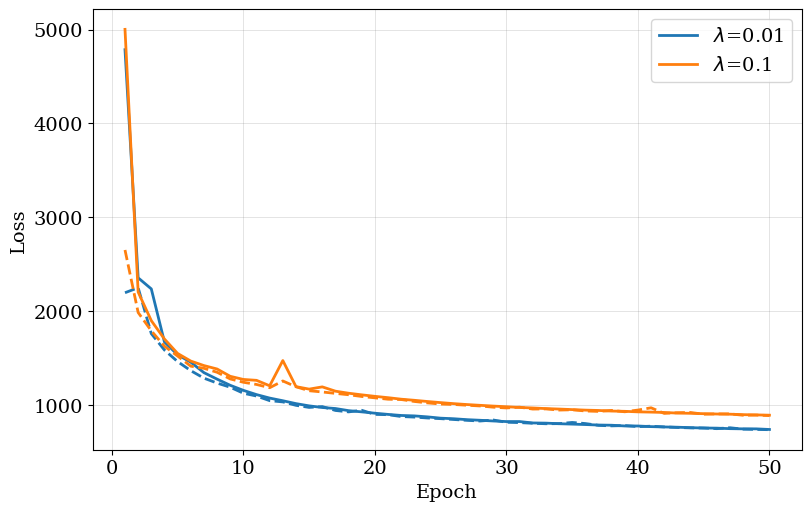

In [16]:
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
ax.grid(True, which='both', ls='-', lw=0.5, c='grey', alpha=0.3)

for i in range(len(train_losses)):
    epochs = np.arange(1, len(train_losses[i])+1)

    ax.plot(epochs, train_losses[i], ls="-", color=hex_colors[i], lw=2, label=f"$\lambda$={lambdas[i]}")
    ax.plot(epochs, test_losses[i], ls="--", color=hex_colors[i], lw=2)

ax.legend()

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# ax.set_yscale('log')

# fig.savefig("./plots/losses.png", dpi=300, facecolor="w")

plt.show()

## Image Reconstruction

In [16]:
vae = BalleFFP(N=128, M=192, k2=3, c=3, format=CH_FORMAT)

if CH_FORMAT == 'channels_first':
    x = tf.zeros((1, 3, 96, 96))
    
elif CH_FORMAT == 'channels_last':
    x = tf.zeros((1, 96, 96, 3))
else:
    raise ValueError("CH_FORMAT must be either 'channels_first' or 'channels_last'")

# call the model to create the weights
_ = vae(x)
    
# load the weights from the .h5 file
# vae_list.append(vae.load_weights(model_path))

2023-03-07 16:15:53.556705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
img, ids = select_random_images(data, 1)

Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l0.01_cr1_20230307041231.h5
Bitrate shape: (1, 9, 9)


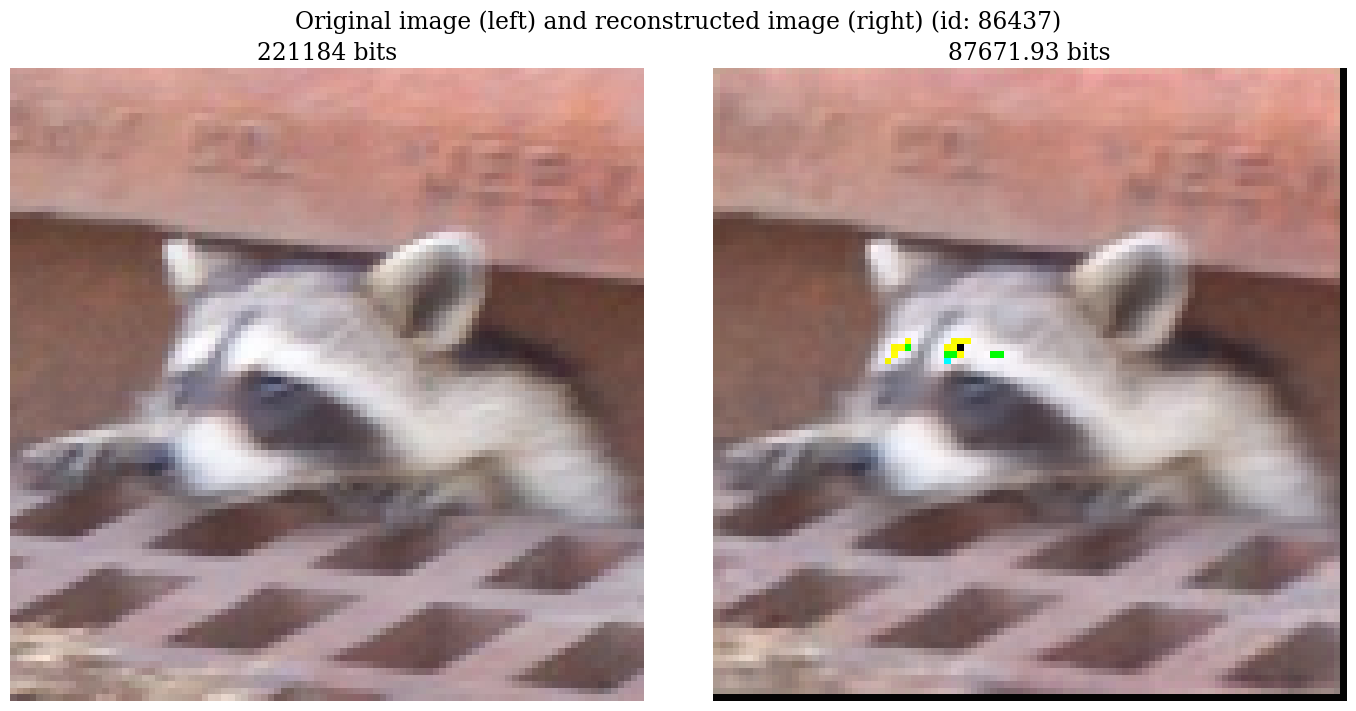

Loading model from: ../models/model_ffp_channels_last_epochs50_normFalse_l0.1_cr1_20230307055327.h5
Bitrate shape: (1, 9, 9)


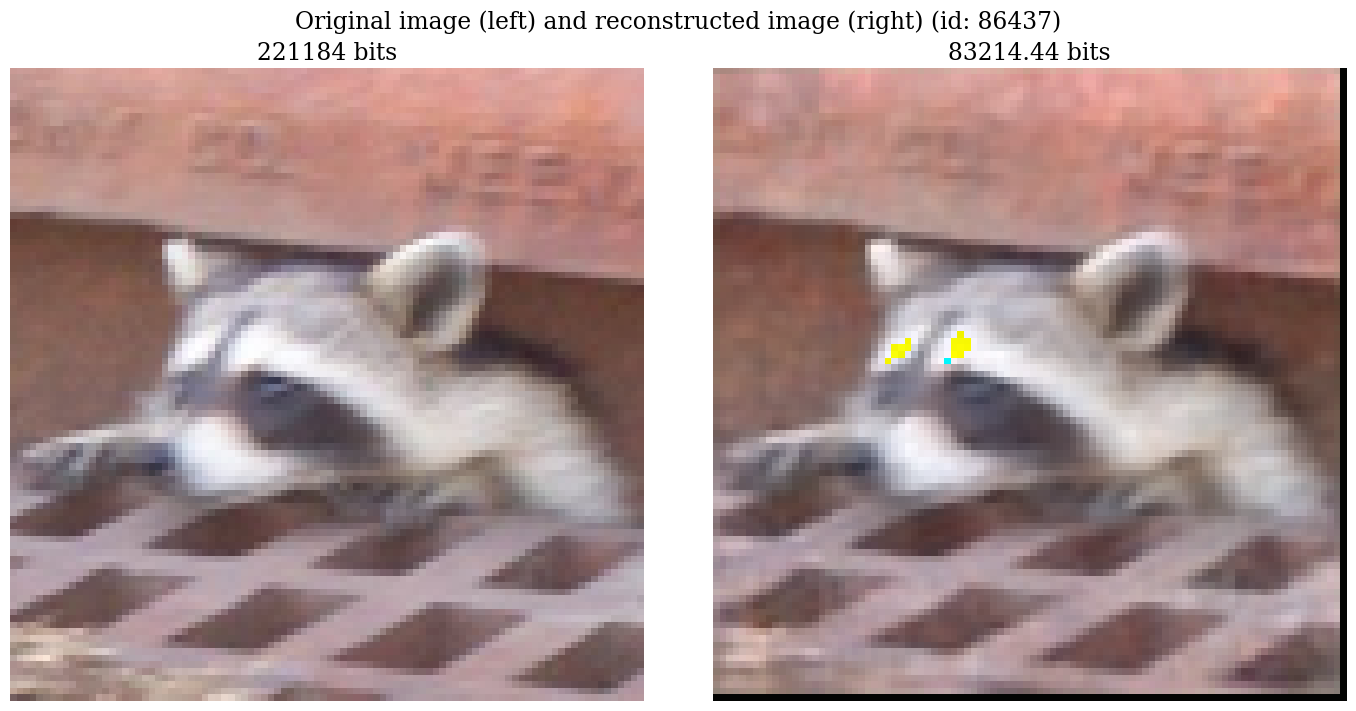

In [23]:
for model_path in models_path:
    print("Loading model from: {}".format(model_path))
    vae.load_weights(model_path)
    img_reco, rate_reco = vae(img) # type: ignore
    
    compressor = Compressor(vae, COD_RANK)
    

    for i in range(img.shape[0]):
        show_image_comparison_bitrate(img[i], img_reco[i], ids[i], CH_FORMAT, compressor)